# Shooting Methods

Key concept: given a set of inputs, integrate the motion forwards and determine a cost.  Use that cost, as a function of the inputs, in a numerical optimizer: find the control inputs that minimize the cost.

## Single Shooting

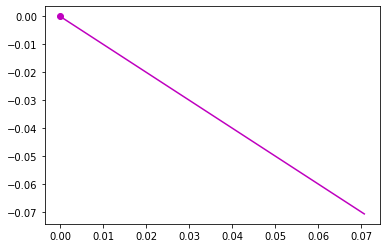

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from math import cos,sin
x0 = np.array([0,0,-np.pi/4.])
d = np.array([0,0.1])

plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.show()

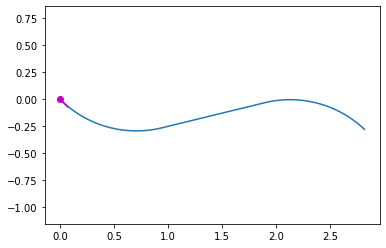

In [2]:
def f(x,u):
    return(np.array([u[0]*cos(x[2]),u[0]*sin(x[2]),u[0]*u[1]]))

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

uv = np.array([[1.,1.],[1.,0.],[1.,-1.],[1.,0.]])
tv = np.array([0.,1.,2.,3.])
ut = interp1d(tv,uv,axis=0,kind='previous')

def fc(t,x):
    u = ut(t)
    return(f(x,u))

te=np.linspace(0.,max(tv),100)
r = solve_ivp(fc,(min(te),max(te)),x0,t_eval=te)
plt.plot(r.y[0,:],r.y[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.axis('equal')
plt.show()

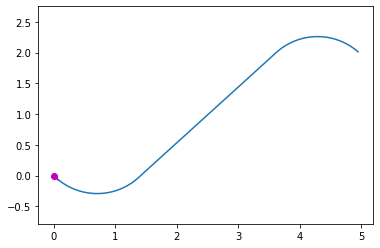

In [3]:
# define decision variable as vector of [time,curv,time,curv,time,curv]
z = np.array([1.5,1.,3.,0.,1.5,-1.])

def path(z):
    # make sure it has even number of elements
    nz = len(z)
    assert(nz%2==0)
    # curvature values
    kv = z[range(1,nz,2)]
    dv = z[range(0,nz,2)]
    #assert(all(dv>0))
    dv = [max(v,0) for v in dv]
    nv = len(kv)
    uv = np.vstack((np.ones((1,nv+1)),np.hstack((kv,0.))))
    tv = np.cumsum(np.append(0,dv))
    te=np.linspace(0.,max(tv),100)
    ut = interp1d(tv,uv,axis=1,kind='previous',bounds_error=False,fill_value='extrapolate')
    def fc(t,x):
        #print(dv,tv,t)
        u = ut(t)
        return(f(x,u))
    r = solve_ivp(fc,(min(te),max(te)),x0,t_eval=te)
    return(r.y)

p = path(z)

plt.plot(p[0,:],p[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.axis('equal')
plt.show()

In [4]:
from scipy.linalg import norm

p_goal = np.array([6.,4.,-np.pi/4])

def J(z):
    p = path(z)
    return(norm(p[0:3,-1]-p_goal))

print(J(z))

2.2510054549543317


In [5]:
curv_lim = 1.1
bnds = [b for ii in range(len(z)//2) for b in [(0.1,10.0),(-curv_lim,curv_lim)]]
bnds

[(0.1, 10.0), (-1.1, 1.1), (0.1, 10.0), (-1.1, 1.1), (0.1, 10.0), (-1.1, 1.1)]

In [6]:
from scipy.optimize import minimize

r = minimize(J,z,method='SLSQP',bounds=bnds)
print(r)

     fun: 1.773390648948118
     jac: array([-1.19568732,  1.97570078, -1.19568732, 14.98799962, -1.19568732,
        2.13597816])
 message: 'Optimization terminated successfully.'
    nfev: 263
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([ 1.69674993,  0.92634189,  3.19674993,  0.16568489,  1.69674993,
       -0.75599448])


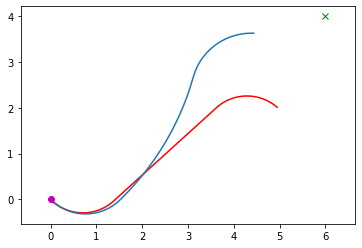

In [7]:
popt = path(r.x)
plt.plot(p[0,:],p[1,:],'r')
plt.plot(popt[0,:],popt[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

In [8]:
def Jsp(z):
    tf = sum(z[range(0,len(z),2)])
    ge = J(z)
    return(0.1*tf+100.*ge)

print(Jsp(z))

225.70054549543318


In [9]:
r = minimize(Jsp,z,method='SLSQP',bounds=bnds)
print(r)

     fun: 142.19087206680865
     jac: array([-99.65486526, 387.88897705, -99.65486526, 862.47616196,
       -99.65486526,  83.45318985])
 message: 'Optimization terminated successfully.'
    nfev: 265
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([ 1.76324297,  1.00601058,  3.38397042,  0.06227713,  1.76324297,
       -0.84611409])


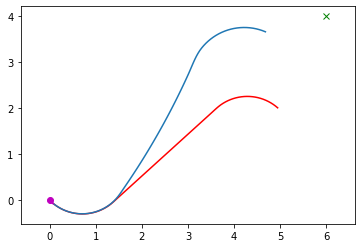

In [10]:
popt = path(r.x)
plt.plot(p[0,:],p[1,:],'r')
plt.plot(popt[0,:],popt[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

In [11]:
def Jspbdd(z):
    J = Jsp(z)
    for (ii,(lo,hi)) in enumerate(bnds):
        if z[ii]>hi:
            J = J + 1e2*(z[ii]-hi)
        elif z[ii]<lo:
            J = J + 1e2*(lo-z[ii])
    return(J)

print(Jspbdd(z))

225.70054549543318


In [12]:
r = minimize(Jspbdd,z,method='Powell')
print(r)

   direc: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.97846800e-03,  1.13256593e-05,  3.68315916e-02,
         2.09450670e-03,  3.98848319e-02,  8.82533724e-03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-7.67023597e-04,  1.05761876e-03,  5.04316343e-03,
         7.98562821e-06, -2.42060209e-03, -1.07401978e-03]])
     fun: 0.8325743361144998
 message: 'Optimization terminated successfully.'
    nfev: 1216
     nit: 10
  status: 0
 success: True
       x: array([ 1.93258515,  0.94175184,  4.73718328, -0.01372296,  1.65594956,
       -0.95545066])


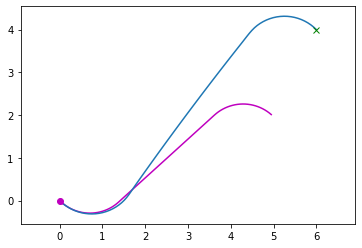

In [13]:
popt = path(r.x)
plt.plot(p[0,:],p[1,:],'m')
plt.plot(popt[0,:],popt[1,:])
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

## Multiple Shooting

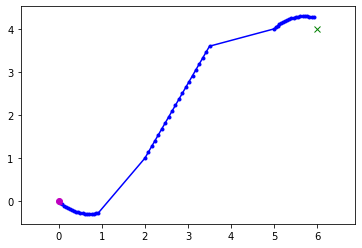

In [14]:
# define decision variable as vector of [time,curv,state,time,curv,state,time,curv]
zm = np.array([1.,1.,   2.,1.,np.pi/3,3.,0.,   5.,4.,np.pi/4,1.,-1.])

def pathm(z):
    # make sure it has N*5 + 2 elements
    nz = len(z)
    assert((nz-2)%5==0)
    # initial curvature values
    ix = 0
    xs = np.array([x0])
    xi = x0
    while ix<nz:
        def fm(t,x):
            u = np.array([1.,z[ix+1]])
            return(f(x,u))
        te=np.linspace(0.,z[ix],20)
        r = solve_ivp(fm,(0.,z[ix]),xi,t_eval=te)
        xs = np.append(xs,np.transpose(r.y),0)
        ix = ix+5
        xi = z[(ix-3):ix]
    return(xs)

p = pathm(zm)

plt.plot(p[:,0],p[:,1],'-b.')
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

In [15]:
def Jm(z):
    tf = sum(z[range(0,len(z),5)])
    p = pathm(z)
    ge = norm(p_goal-p[-1,:])
    for ii in range(20,len(p)-1,20):
        ge=ge+norm(p[ii,:]-p[ii+1,:])
    return(0.1*tf+100.*ge)

print(Jm(zm))

407.96823232122074


In [16]:
x_lim = 10
th_lim = np.pi
bndsm = [b for ii in range(len(z)//2) for b in [(0.1,10.0),(-curv_lim,curv_lim),(-x_lim,x_lim),(-x_lim,x_lim),(-th_lim,th_lim)]]
bndsm = bndsm[0:-3]
assert(len(bndsm)==len(zm))
bndsm

[(0.1, 10.0),
 (-1.1, 1.1),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (-1.1, 1.1),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (-1.1, 1.1)]

In [17]:
r = minimize(Jm,zm,method='SLSQP',bounds=bndsm)
print(r)

     fun: 0.8679541659682287
     jac: array([  86.79000323,   76.43788655,    5.58215756,   -7.7301063 ,
         -9.50207892,   94.76949149,   18.72339013, -148.67160501,
        -93.66740615,   -2.560046  ,  -79.20625395,    3.60567074])
 message: 'Optimization terminated successfully.'
    nfev: 921
     nit: 57
    njev: 57
  status: 0
 success: True
       x: array([ 2.11047805e+00,  8.64800907e-01,  1.81472959e+00,  2.32033444e-01,
        1.03974573e+00,  4.01492687e+00,  3.28596589e-03,  3.82514982e+00,
        3.70731599e+00,  1.05293767e+00,  2.53687776e+00, -7.24643423e-01])


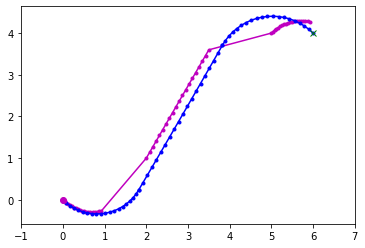

In [18]:
popt = pathm(r.x)

plt.plot(p[:,0],p[:,1],'-m.')
plt.plot(popt[:,0],popt[:,1],'-b.')
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

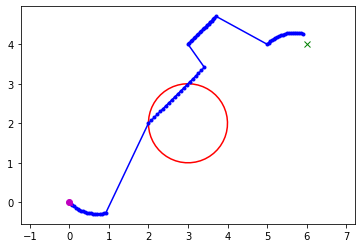

In [19]:
# define decision variable as vector of [time,curv,state,time,curv,state,time,curv]
zmo = np.array([1.,1.,   2.,2.,np.pi/4,2.,0.,   3.,4.,np.pi/4,1.,-0.,   5.,4.,np.pi/4,1.,-1.])
#zmo = np.array([1.,1.,   1.5,-0.5,0.5*np.pi/4,3.,0.,   4.5,1.,2.0*np.pi/4,2.5,0.,   5.,4.,2.0*np.pi/4,2.,-1.])

c_obs = np.array([3,2])
r_obs = 1.
ths = np.linspace(0.,2*np.pi,50)
plt.plot(c_obs[0]+r_obs*np.array([sin(th) for th in ths]),c_obs[1]+r_obs*np.array([cos(th) for th in ths]),'r-')

p = pathm(zmo)

plt.plot(p[:,0],p[:,1],'-b.')
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.axis('equal')
plt.show()

In [20]:
def Jmo(z):
    tf = sum(z[range(0,len(z),5)])
    p = pathm(z)
    ge = norm(p_goal-p[-1,:])
    for ii in range(20,len(p)-1,20):
        ge=ge+norm(p[ii,:]-p[ii+1,:])
    op = 0.
    for pp in p:
        inc = r_obs - norm(pp[0:2]-c_obs)
        if inc>0:
            op = op + inc
    return(0.1*tf+100.*ge + 50.*op)

print(Jmo(zm))

632.4732524609317


In [21]:
bndsmo = [b for ii in range((7+len(zmo))//5) for b in [(0.1,10.0),(-curv_lim,curv_lim),(-x_lim,x_lim),(-x_lim,x_lim),(-th_lim,th_lim)]]
bndsmo = bndsmo[0:-3]
assert(len(bndsmo)==len(zmo))
bndsmo

[(0.1, 10.0),
 (-1.1, 1.1),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (-1.1, 1.1),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (-1.1, 1.1),
 (-10, 10),
 (-10, 10),
 (-3.141592653589793, 3.141592653589793),
 (0.1, 10.0),
 (-1.1, 1.1)]

In [22]:
r = minimize(Jmo,zmo,method='SLSQP',bounds=bndsmo)
print(r)

     fun: 0.9263414300776707
     jac: array([-129.89550281, -316.19088011,   45.80610711,   66.09987354,
        -72.03610168,   56.88321523, -222.44499324,   62.07358045,
          4.20651154,  -46.82917234,   91.16206406, -135.29060832,
        -64.45134581,  -36.02801347,   41.3363408 ,   -6.45902839,
        183.00906218])
 message: 'Optimization terminated successfully.'
    nfev: 1508
     nit: 71
    njev: 71
  status: 0
 success: True
       x: array([ 2.72997308,  0.90820806,  1.87130421,  0.91384868,  1.69398614,
        1.8175965 , -0.33668668,  2.19656482,  2.67340552,  1.08202621,
        2.35721409, -0.2501117 ,  3.8362889 ,  4.31919867,  0.49245881,
        2.34334399, -0.54531182])


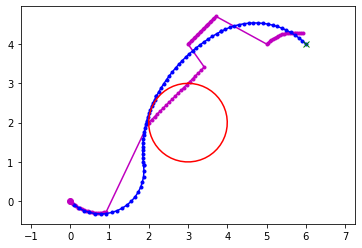

In [23]:
popt = pathm(r.x)

plt.plot(p[:,0],p[:,1],'-m.')
plt.plot(popt[:,0],popt[:,1],'-b.')
plt.plot(c_obs[0]+r_obs*np.array([sin(th) for th in ths]),c_obs[1]+r_obs*np.array([cos(th) for th in ths]),'r-')
plt.plot(x0[0]+d*cos(x0[2]),x0[1]+d*sin(x0[2]),'m')
plt.plot(x0[0],x0[1],'mo')
plt.plot(p_goal[0],p_goal[1],'gx')
plt.plot()
plt.axis('equal')
plt.show()